# COVID-RS

O objetivo desta tarefa é utilizar e avaliar técnicas de aprendizado de máquina em uma base de dados real. Esta base é originada da Secretaria Estadual de Saúde do RS e contém todos casos registrados de COVID-19 no estado, com informações diversas sobre cada caso, incluindo informações de hospitalização e óbito. 

A tarefa dos modelos desenvolvidos será tentar classificar se um indivíduo será ou não hospitalizado, com base nos dados da secretaria.

## Carregamento dos dados

In [1]:
# Download dos dados da Secretaria de Saude e renomeação para algo mais usável 
# Os dados são atualizados diariamente

!wget https://ti.saude.rs.gov.br/covid19/download
!mv download dados_covid_rs.csv

--2020-12-05 22:47:40--  https://ti.saude.rs.gov.br/covid19/download
Resolving ti.saude.rs.gov.br (ti.saude.rs.gov.br)... 200.198.173.170
Connecting to ti.saude.rs.gov.br (ti.saude.rs.gov.br)|200.198.173.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘download’

download                [   <=>              ]  69,37M  2,03MB/s    in 63s     

2020-12-05 22:48:44 (1,10 MB/s) - ‘download’ saved [72737860]



In [2]:
# Carregamento dos dados em dataframe Pandas.
# O separador de colunas no arquivo é ponto e vírgula.

import pandas as pd
df = pd.read_csv("dados_covid_rs.csv", delimiter=';')
df.head()

,COD_IBGE,MUNICIPIO,COD_REGIAO_COVID,REGIAO_COVID,SEXO,FAIXAETARIA,CRITERIO,DATA_CONFIRMACAO,DATA_SINTOMAS,DATA_EVOLUCAO,...,DATA_INCLUSAO_OBITO,DATA_EVOLUCAO_ESTIMADA,RACA_COR,ETNIA_INDIGENA,PROFISSIONAL_SAUDE,BAIRRO,HOSPITALIZACAO_SRAG,FONTE_INFORMACAO,PAIS_NASCIMENTO,PES_PRIV_LIBERDADE
0,430003,ACEGUÁ,16,BAGE - R22,Masculino,50 a 59,RT-PCR,05/11/2020,02/11/2020,NaN,...,NaN,16/11/2020,BRANCA,NAO ENCONTRADO,NAO,ZONA RURAL,NAO,E-SUS,BRASIL,NAO
1,430003,ACEGUÁ,16,BAGE - R22,Feminino,50 a 59,TESTE RÁPIDO,19/10/2020,05/10/2020,NaN,...,NaN,19/10/2020,BRANCA,NAO ENCONTRADO,NAO,ZONA RURAL,NAO,E-SUS,BRASIL,NAO
2,430003,ACEGUÁ,16,BAGE - R22,Masculino,20 a 29,RT-PCR,09/11/2020,06/11/2020,NaN,...,NaN,20/11/2020,BRANCA,NAO ENCONTRADO,NAO,ZONA RURAL,NAO,E-SUS,BRASIL,NAO
3,430003,ACEGUÁ,16,BAGE - R22,Feminino,50 a 59,RT-PCR,26/11/2020,18/11/2020,01/12/2020,...,NaN,NaN,BRANCA,NAO ENCONTRADO,NAO INFORMADO,ASSENTAMENTO,SIM,SIVEP HOSP,BRASIL,NAO
4,430003,ACEGUÁ,16,BAGE - R22,Masculino,50 a 59,Outros Testes,04/11/2020,04/11/2020,NaN,...,NaN,18/11/2020,BRANCA,NAO ENCONTRADO,NAO,ZONA RURAL,NAO,E-SUS,BRASIL,NAO


In [3]:
# Qual o tamanho da tabela (linhas, colunas)?
df.shape

(346801, 29)

In [4]:
# Quais são as colunas e tipos de dados?
df.dtypes

COD_IBGE                   int64
MUNICIPIO                 object
COD_REGIAO_COVID           int64
REGIAO_COVID              object
SEXO                      object
FAIXAETARIA               object
CRITERIO                  object
DATA_CONFIRMACAO          object
DATA_SINTOMAS             object
DATA_EVOLUCAO             object
EVOLUCAO                  object
HOSPITALIZADO             object
FEBRE                     object
TOSSE                     object
GARGANTA                  object
DISPNEIA                  object
OUTROS                    object
CONDICOES                 object
GESTANTE                  object
DATA_INCLUSAO_OBITO       object
DATA_EVOLUCAO_ESTIMADA    object
RACA_COR                  object
ETNIA_INDIGENA            object
PROFISSIONAL_SAUDE        object
BAIRRO                    object
HOSPITALIZACAO_SRAG       object
FONTE_INFORMACAO          object
PAIS_NASCIMENTO           object
PES_PRIV_LIBERDADE        object
dtype: object

## Pré-processamento

A etapa de pré-processamento é necessária para adequar os tipos de dados, tratar dados faltantes, descartar dados que não serão utilizado e também criar novos atributos.

### Remoção de colunas desnecessárias

Alguns dados presentes que se referem à localidades e/ou código dessas, potencialmente não são relevantes para predição sem a agregação de informações externas. Portanto, serão removidos, pois não serão utilizadas fontes de dados externas.

In [5]:
del df['COD_IBGE']
del df['MUNICIPIO']
del df['COD_REGIAO_COVID']
del df['REGIAO_COVID']
del df['BAIRRO']
del df['PAIS_NASCIMENTO']

Dados sobre evolução da doença e óbito provavelmente são dados que vazam informações sobre a hospitalização, então também serão desconsiderados.

In [6]:
del df['DATA_EVOLUCAO']
del df['EVOLUCAO']
del df['DATA_INCLUSAO_OBITO']
del df['DATA_EVOLUCAO_ESTIMADA']
del df['HOSPITALIZACAO_SRAG']

Além disso, outros dados que provavelmente não tem relação com o agravamento da doença e hospitalização, serão descartados.

In [7]:
del df['PROFISSIONAL_SAUDE']
del df['FONTE_INFORMACAO']
del df['CRITERIO']

Os campos de ETNIA_INDIGENA e CONDICOES, podem ter relação com a hospitalização. Contudo, é preciso saber se são dados tratáveis. Para isso, é possível verificar a quantidade de valores possíveis para cada atributo.

In [8]:
nao_nulo = pd.notnull(df['CONDICOES'])

In [9]:
# Uma amostra aleatória dos valores para se ter noção do que tem nos dados
# (amostra sem pegar valores nulos ou 'não encontrados')
df[['CONDICOES']][nao_nulo].sample(10, random_state=666)

,CONDICOES
327322,Doença Cardiovascular Crônica
179134,Doença Cardiovascular Crônica
181610,"Doença Cardiovascular Crônica, Doença Hepática..."
251117,"Doença Cardiovascular Crônica, Obesidade"
5896,Doenças cardíacas crônicas
197481,Doenças cardíacas crônicas
323367,Outros
186145,"Doença Cardiovascular Crônica, Doença Neurológ..."
42574,"Doença Cardiovascular Crônica, Outros"
310052,Obesidade


In [10]:
len(df['CONDICOES'].unique())

762

In [11]:
nao_nulo = pd.notnull(df['ETNIA_INDIGENA'])

In [12]:
# Uma amostra aleatória dos valores para se ter noção do que tem nos dados
# (amostra sem pegar valores nulos ou 'não encontrados')
df[['ETNIA_INDIGENA']][nao_nulo & (df['ETNIA_INDIGENA'] != 'NAO ENCONTRADO')].sample(10, random_state=666)

,ETNIA_INDIGENA
78137,KAINGANG (CAINGANGUE)
323237,KAINGANG (CAINGANGUE)
109272,KAINGANG (CAINGANGUE)
88261,KAINGANG (CAINGANGUE)
133333,KAINGANG (CAINGANGUE)
148592,KAINGANG (CAINGANGUE)
252923,KAINGANG (CAINGANGUE)
306199,KAINGANG (CAINGANGUE)
43,KAINGANG (CAINGANGUE)
142914,KAINGANG (CAINGANGUE)


In [13]:
len(df['ETNIA_INDIGENA'].unique())

21

Ambos atributos tem muitos valores possíveis, o que geraria muitas colunas com one hot enconding. Além disso, as `CONDICOES` estão em formato de lista, e provavelmente precisariam de uma aplicação de técnicas de Processamento de Linguagem Natural (PLN) para definição de classes. Por isso, essas colunas também serão deletadas, para diminuição da complexidade dos dados.

In [14]:
del df['ETNIA_INDIGENA']
del df['CONDICOES']

### Formatação das datas

As datas são reconhecidas com formato de _string_ ou _object_ , como mostrado na seção de carregamento dos dados. Assim, se torna necessária a formatação para o tipo data (pandas.DateTime).

In [15]:
df["DATA_CONFIRMACAO"] = pd.to_datetime(df["DATA_CONFIRMACAO"], format="%d/%m/%Y")
df["DATA_SINTOMAS"] = pd.to_datetime(df["DATA_SINTOMAS"], format="%d/%m/%Y")

df

,SEXO,FAIXAETARIA,DATA_CONFIRMACAO,DATA_SINTOMAS,HOSPITALIZADO,FEBRE,TOSSE,GARGANTA,DISPNEIA,OUTROS,GESTANTE,RACA_COR,PES_PRIV_LIBERDADE
0,Masculino,50 a 59,2020-11-05,2020-11-02,NAO,NAO,SIM,NAO,NAO,NAO,NAO,BRANCA,NAO
1,Feminino,50 a 59,2020-10-19,2020-10-05,NAO,NAO,NAO,NAO,NAO,NAO,NAO,BRANCA,NAO
2,Masculino,20 a 29,2020-11-09,2020-11-06,NAO,NAO,SIM,NAO,NAO,NAO,NAO,BRANCA,NAO
3,Feminino,50 a 59,2020-11-26,2020-11-18,SIM,SIM,NAO,NAO,SIM,NAO,NAO,BRANCA,NAO
4,Masculino,50 a 59,2020-11-04,2020-11-04,NAO,NAO,NAO,NAO,NAO,NAO,NAO,BRANCA,NAO
...,...,...,...,...,...,...,...,...,...,...,...,...,...
346796,Masculino,30 a 39,2020-11-21,2020-11-21,NAO,NAO,NAO,NAO,NAO,SIM,NAO,NAO INFORMADO,NAO
346797,Feminino,40 a 49,2020-11-20,2020-11-15,NAO,NAO,SIM,NAO,NAO,NAO,NAO,BRANCA,NAO
346798,Feminino,50 a 59,2020-11-16,2020-11-05,NAO,NAO,NAO,SIM,NAO,NAO,NAO,NAO INFORMADO,NAO
346799,Feminino,50 a 59,2020-10-29,2020-10-25,NAO,NAO,NAO,NAO,SIM,NAO,NAO,BRANCA,NAO


### Remoção de confirmações recentes

Seleção de datas de confirmação com um intervalo de 15 dias, pois confirmações recentes podem não ser um bom indicativo para prever hospitalização.

In [16]:
df = df.drop(df[df['DATA_CONFIRMACAO'] > '2020-11-15'].index)
df

,SEXO,FAIXAETARIA,DATA_CONFIRMACAO,DATA_SINTOMAS,HOSPITALIZADO,FEBRE,TOSSE,GARGANTA,DISPNEIA,OUTROS,GESTANTE,RACA_COR,PES_PRIV_LIBERDADE
0,Masculino,50 a 59,2020-11-05,2020-11-02,NAO,NAO,SIM,NAO,NAO,NAO,NAO,BRANCA,NAO
1,Feminino,50 a 59,2020-10-19,2020-10-05,NAO,NAO,NAO,NAO,NAO,NAO,NAO,BRANCA,NAO
2,Masculino,20 a 29,2020-11-09,2020-11-06,NAO,NAO,SIM,NAO,NAO,NAO,NAO,BRANCA,NAO
4,Masculino,50 a 59,2020-11-04,2020-11-04,NAO,NAO,NAO,NAO,NAO,NAO,NAO,BRANCA,NAO
5,Feminino,15 a 19,2020-11-06,2020-11-06,NAO,NAO,NAO,NAO,NAO,NAO,NAO,BRANCA,NAO
...,...,...,...,...,...,...,...,...,...,...,...,...,...
346793,Masculino,30 a 39,2020-11-15,2020-11-15,NAO,NAO,NAO,NAO,NAO,SIM,NAO,NAO INFORMADO,NAO
346794,Feminino,80 e mais,2020-11-15,2020-11-08,NAO,NAO,SIM,SIM,SIM,NAO,NAO,NAO INFORMADO,NAO
346795,Feminino,40 a 49,2020-10-28,2020-10-22,SIM,SIM,SIM,NAO,SIM,NAO,NAO,BRANCA,NAO
346799,Feminino,50 a 59,2020-10-29,2020-10-25,NAO,NAO,NAO,NAO,SIM,NAO,NAO,BRANCA,NAO


A quantidade de valores faltantes em cada coluna, podem influenciar como serão preenchidos.

### Valores Faltantes

Algumas colunas possuem vários "NaN" (Not a Number) ou "NaT" (Not a Time), indicando que são
valores faltantes.

Há diversas maneiras de lidar com buracos nos dados, vamos primeiro quantificar o problema contando o
número de valores faltantes por coluna.

In [17]:
rows = []
for column in df.columns:
    row = {'coluna': column, 'nans': df[column].isnull().sum(),
           'frac_nans': df[column].isnull().sum() / df.shape[0]}
    rows.append(row)
           
res = pd.DataFrame(rows)
res[res.nans>0].sort_values('nans', ascending=False)

,coluna,nans,frac_nans
8,DISPNEIA,3629,0.012275
5,FEBRE,20,0.000068
6,TOSSE,20,0.000068
7,GARGANTA,20,0.000068
9,OUTROS,20,0.000068


#### DISPNEIA

A coluna `DISPNEIA` apresenta 1% de valores faltantes, essa informação pode ser importante. Por isso, vamos utilizar a função `fillna` do pandas, que preenche valores faltantes com algum valor. Será atribuído "FALTANDO", para esses buracos.

In [18]:
df["DISPNEIA"].unique()

array(['NAO', 'SIM', nan], dtype=object)

In [19]:
df['DISPNEIA'] = df["DISPNEIA"].fillna("FALTANDO")

In [20]:
df["DISPNEIA"].unique()

array(['NAO', 'SIM', 'FALTANDO'], dtype=object)

#### Colunas com menos de 1% faltantes

Para as colunas com menos de 1% de valores faltantes, será utilizada outra técnica para preenchimento.
Aqui será feito um preenchimento aleatório com SIM ou NAO, respeitando a distribuição dos dados.

In [21]:
import numpy as np

In [22]:
c = res[(res['frac_nans'] < 0.01) & (res['frac_nans'] > 0)]
colunas = c['coluna'].values

In [23]:
for coluna in colunas:
    dist = df[coluna].value_counts(normalize=True)
    faltantes = df[coluna].isnull()
    df.loc[faltantes,coluna] = np.random.choice(dist.index, size=
len(df[faltantes]), p=dist.values)

### Extensão de Atributos

Uma técnica bastante utilizada é a geração de novos atributos baseados em atributos já existentes. Aqui, será criada uma nova coluna com a diferença (em dias) entre a data de confirmação e a data de sintomas.

In [24]:
df['DIAS_SINTOMAS'] = df["DATA_CONFIRMACAO"] - df["DATA_SINTOMAS"]
df['DIAS_SINTOMAS'] = (df['DIAS_SINTOMAS'] / np.timedelta64(1, 'D')).astype(int)

In [25]:
# Remoção das datas pois será usado apenas o novo atributo gerado
df = df.drop(['DATA_CONFIRMACAO', 'DATA_SINTOMAS'], axis=1)

In [26]:
df.head()

,SEXO,FAIXAETARIA,HOSPITALIZADO,FEBRE,TOSSE,GARGANTA,DISPNEIA,OUTROS,GESTANTE,RACA_COR,PES_PRIV_LIBERDADE,DIAS_SINTOMAS
0,Masculino,50 a 59,NAO,NAO,SIM,NAO,NAO,NAO,NAO,BRANCA,NAO,3
1,Feminino,50 a 59,NAO,NAO,NAO,NAO,NAO,NAO,NAO,BRANCA,NAO,14
2,Masculino,20 a 29,NAO,NAO,SIM,NAO,NAO,NAO,NAO,BRANCA,NAO,3
4,Masculino,50 a 59,NAO,NAO,NAO,NAO,NAO,NAO,NAO,BRANCA,NAO,0
5,Feminino,15 a 19,NAO,NAO,NAO,NAO,NAO,NAO,NAO,BRANCA,NAO,0


### Formatação

Para que um modelo de Aprendizado de Máquina possa ler os dados, eles precisam de algumas adaptações. Aqui será realizada uma transformação de categorias para dados numéricos.

#### Binarização

O atributo `SEXO` não possui ordinalidade, mas como são apenas duas classes no conjunto de dados, serão apenas binarizadas.

In [27]:
df['SEXO'].unique()

array(['Masculino', 'Feminino'], dtype=object)

In [28]:
df['SEXO'] = df['SEXO'].replace('Feminino', 1)
df['SEXO'] = df['SEXO'].replace('Masculino', 0)

Todas as colunas que possuem apenas `SIM` ou `NAO` também podem ser facilmente binarizadas

In [29]:
binarizar_col = ['HOSPITALIZADO', 'FEBRE', 'TOSSE', 'GARGANTA',
                 'OUTROS', 'GESTANTE', 'PES_PRIV_LIBERDADE']

for col in binarizar_col:  
    df[col] = df[col].replace('SIM', 1)
    df[col] = df[col].replace('NAO', 0)

#### Mapeamento

Já o atributo de faixa etária possui várias opções de preenchimento, contudo é possível tratar com ordinalidade. Pelo que se tem conhecimento até agora, as pessoas mais velhas tem mais risco de agravamento da doença. Portanto, podemos utilizar um mapeamento das faixas etárias de forma ordenada.

In [30]:
map_faixa = {
    '<1'        : 0,
    '01 a 04'   : 1,
    '05 a 09'   : 2,
    '10 a 14'   : 3,
    '15 a 19'   : 4,
    '20 a 29'   : 5,
    '30 a 39'   : 6,
    '40 a 49'   : 7,
    '50 a 59'   : 8,
    '60 a 69'   : 9,
    '70 a 79'   : 10,
    '80 e mais' : 11    
}

In [31]:
df['FAIXAETARIA'] = df['FAIXAETARIA'].map(lambda x: map_faixa[x])

#### One hot enconding

Para os outros atributos que possuem mais opções de rótulos possíveis, uma abordagem comum é utilizar _one hot enconding_ , tranformando cada opção em uma coluna binária. Para isso, será usada a função LabelBinarizer, do scikit-learn.

In [32]:
from sklearn.preprocessing import LabelBinarizer

In [33]:
df['RACA_COR'].unique()

array(['BRANCA', 'INDIGENA', 'AMARELA', 'NAO INFORMADO', 'PARDA', 'PRETA'],
      dtype=object)

In [34]:
df = df.reset_index()

O atributo `RACA_COR` possui alguns tipos, cada um deles será transformado em uma nova coluna binária, exceto a opção 'NAO INFORMADO', pois essa será indicada por todas colunas com valor zero.

In [35]:
# cod é o codificador genérico 
cod = LabelBinarizer()
cod.fit(df['RACA_COR'])

# Com o codificador "treinado", convertemos os dados na coluna desejada
atributo_transformado = cod.transform(df['RACA_COR'])

# Agora reconvertemos para um dataframe em pandas 
# Mudamos o nome das colunas para refletir os valores originais
onehot = pd.DataFrame(atributo_transformado)
onehot.columns = cod.classes_

# Juntamos de volta com os dados originais e removemos a coluna categórica e a coluna de 'não informado'
df = pd.concat([df, onehot], axis=1).drop(['RACA_COR', 'NAO INFORMADO'], axis=1)
df

,index,SEXO,FAIXAETARIA,HOSPITALIZADO,FEBRE,TOSSE,GARGANTA,DISPNEIA,OUTROS,GESTANTE,PES_PRIV_LIBERDADE,DIAS_SINTOMAS,AMARELA,BRANCA,INDIGENA,PARDA,PRETA
0,0,0,8,0,0,1,0,NAO,0,0,0,3,0,1,0,0,0
1,1,1,8,0,0,0,0,NAO,0,0,0,14,0,1,0,0,0
2,2,0,5,0,0,1,0,NAO,0,0,0,3,0,1,0,0,0
3,4,0,8,0,0,0,0,NAO,0,0,0,0,0,1,0,0,0
4,5,1,4,0,0,0,0,NAO,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295640,346793,0,6,0,0,0,0,NAO,1,0,0,0,0,0,0,0,0
295641,346794,1,11,0,0,1,1,SIM,0,0,0,7,0,0,0,0,0
295642,346795,1,7,1,1,1,0,SIM,0,0,0,6,0,1,0,0,0
295643,346799,1,8,0,0,0,0,SIM,0,0,0,4,0,1,0,0,0


In [36]:
df['DISPNEIA'].unique()

array(['NAO', 'SIM', 'FALTANDO'], dtype=object)

In [37]:
# cod é o codificador genérico
cod = LabelBinarizer()
cod.fit(df['DISPNEIA'])

# Com o codificador "treinado", convertemos os dados na coluna desejada
atributo_transformado = cod.transform(df['DISPNEIA'])

# Agora reconvertemos para um dataframe em pandas 
# Mudamos o nome das colunas para refletir os valores originais
onehot = pd.DataFrame(atributo_transformado)
onehot.columns = cod.classes_

# Juntamos de volta com os dados originais e removemos a coluna categórica e a coluna de 'faltando'
df = pd.concat([df, onehot], axis=1).drop(['DISPNEIA', 'FALTANDO'], axis=1)
df

,index,SEXO,FAIXAETARIA,HOSPITALIZADO,FEBRE,TOSSE,GARGANTA,OUTROS,GESTANTE,PES_PRIV_LIBERDADE,DIAS_SINTOMAS,AMARELA,BRANCA,INDIGENA,PARDA,PRETA,NAO,SIM
0,0,0,8,0,0,1,0,0,0,0,3,0,1,0,0,0,1,0
1,1,1,8,0,0,0,0,0,0,0,14,0,1,0,0,0,1,0
2,2,0,5,0,0,1,0,0,0,0,3,0,1,0,0,0,1,0
3,4,0,8,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,5,1,4,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295640,346793,0,6,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
295641,346794,1,11,0,0,1,1,0,0,0,7,0,0,0,0,0,0,1
295642,346795,1,7,1,1,1,0,0,0,0,6,0,1,0,0,0,0,1
295643,346799,1,8,0,0,0,0,0,0,0,4,0,1,0,0,0,0,1


### Reordenação das colunas

In [38]:
# Reposicionamento da coluna HOSPITALIZADO, que será nosso valor alvo
valores_alvo = df['HOSPITALIZADO'].values
df = df.drop('HOSPITALIZADO', axis=1)
df['HOSPITALIZADO'] = valores_alvo

## Balanceamento do _dataset_

Para o balanceamento do conjunto de dados, será aplicada uma técnica chamada de _downsample_. Essa técnica consiste em remover exemplos aleatórios da classe majoritária de forma que a quantidade seja igual ou próxima da classe menos evidente.

In [39]:
df['HOSPITALIZADO'].value_counts()

0    272821
1     22824
Name: HOSPITALIZADO, dtype: int64

In [40]:
df = df.drop(df[df['HOSPITALIZADO'] == 0].sample(272821-22824).index)

In [41]:
df['HOSPITALIZADO'].value_counts()

1    22824
0    22824
Name: HOSPITALIZADO, dtype: int64

## Definição Treino/Validação e Teste

Usualmente a matriz que representa os atributos é chamada de `X` e o vetor de valores alvo (o atributo da classificação) é representado por `y`.

In [42]:
X = df.drop('HOSPITALIZADO', axis=1)
y = df['HOSPITALIZADO']

Utilizando a função `train_test_split`do scikit learn, faremos a divisão entre conjunto de _dev_ (treino e validação) e conjunto de teste

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
df['HOSPITALIZADO'].value_counts()

1    22824
0    22824
Name: HOSPITALIZADO, dtype: int64

Divisão do conjunto de __desenvolvimento__ (respectivo ao treino e validação), que será utilizado para busca de parâmetros; e o conjunto de __teste__, que será utilizado para avaliar o desempenho do modelo selecionado.

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=666)

## Validação Cruzada & Grid Search

Com o conjunto de desenvolvimento, podemos realizar a busca pelos melhores hiperparâmetros para o modelo. Para isso, podemos utilizar a função do scikit-learn `GridSearchCV`, que realiza uma busca exaustiva nos parâmetros definidos por um dicionário de parâmetros. Além disso, esse método também aplica a validação cruzada, dessa forma é possível buscar os hiperparâmetros e também realizar o primeiro processo da validação cruzada aninhada.

Além disso, serão realizadas buscas de hiper-parâmetros em três diferentes modelos. Assim, o modelo que tiver o melhor desempenho na etapa de desenvolvimento, será selecionado para ser aplicado no teste.

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import classification_report

### Random Forest

In [47]:
# Set the parameters by cross-validation
tuned_parameters = [
    {'criterion' : ['gini'], 'n_estimators' : [100, 200],
     'max_depth' : [None, 100], 'bootstrap' : [True, False]
    }
]

scores = ['accuracy']

In [48]:
for score in scores:
    print("# Tunando hyper-parâmetros para %s" % score)
    print()

    clf_rfc = GridSearchCV(
        RFC(), tuned_parameters, scoring='%s' % score
    )
    clf_rfc.fit(X_train, y_train)

    print("Melhores parâmetros no conjunto de desenvolvimento:")
    print()
    print(clf_rfc.best_params_)
    print()
    print("Resultados do grid:")
    print()
    means = clf_rfc.cv_results_['mean_test_score']
    stds = clf_rfc.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf_rfc.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

# Tunando hyper-parâmetros para accuracy

Melhores parâmetros no conjunto de desenvolvimento:

{'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'n_estimators': 200}

Resultados do grid:

0.868 (+/-0.010) for {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'n_estimators': 100}
0.869 (+/-0.008) for {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'n_estimators': 200}
0.868 (+/-0.010) for {'bootstrap': True, 'criterion': 'gini', 'max_depth': 100, 'n_estimators': 100}
0.869 (+/-0.008) for {'bootstrap': True, 'criterion': 'gini', 'max_depth': 100, 'n_estimators': 200}
0.859 (+/-0.010) for {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'n_estimators': 100}
0.859 (+/-0.008) for {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'n_estimators': 200}
0.858 (+/-0.008) for {'bootstrap': False, 'criterion': 'gini', 'max_depth': 100, 'n_estimators': 100}
0.859 (+/-0.009) for {'bootstrap': False, 'criterion': 'gini', 'max_depth': 100, 'n_esti

### MLP

In [49]:
# Set the parameters by cross-validation
tuned_parameters = [
    {'hidden_layer_sizes' : [(100,), (50,50)],
     'activation' : ['relu', 'logistic'],
     'solver' : ['sgd', 'adam'],
    }
]

scores = ['accuracy']

In [50]:
for score in scores:
    print("# Tunando hyper-parâmetros para %s" % score)
    print()

    clf_mlp = GridSearchCV(
        MLP(), tuned_parameters, scoring='%s' % score
    )
    clf_mlp.fit(X_train, y_train)

    print("Melhores parâmetros no conjunto de desenvolvimento:")
    print()
    print(clf_mlp.best_params_)
    print()
    print("Resultados do grid:")
    print()
    means = clf_mlp.cv_results_['mean_test_score']
    stds = clf_mlp.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf_mlp.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

# Tunando hyper-parâmetros para accuracy

Melhores parâmetros no conjunto de desenvolvimento:

{'activation': 'relu', 'hidden_layer_sizes': (100,), 'solver': 'adam'}

Resultados do grid:

0.500 (+/-0.000) for {'activation': 'relu', 'hidden_layer_sizes': (100,), 'solver': 'sgd'}
0.572 (+/-0.195) for {'activation': 'relu', 'hidden_layer_sizes': (100,), 'solver': 'adam'}
0.500 (+/-0.000) for {'activation': 'relu', 'hidden_layer_sizes': (50, 50), 'solver': 'sgd'}
0.560 (+/-0.181) for {'activation': 'relu', 'hidden_layer_sizes': (50, 50), 'solver': 'adam'}
0.500 (+/-0.000) for {'activation': 'logistic', 'hidden_layer_sizes': (100,), 'solver': 'sgd'}
0.500 (+/-0.000) for {'activation': 'logistic', 'hidden_layer_sizes': (100,), 'solver': 'adam'}
0.500 (+/-0.000) for {'activation': 'logistic', 'hidden_layer_sizes': (50, 50), 'solver': 'sgd'}
0.500 (+/-0.000) for {'activation': 'logistic', 'hidden_layer_sizes': (50, 50), 'solver': 'adam'}



### KNN

In [51]:
# Set the parameters by cross-validation
tuned_parameters = [
    {'n_neighbors' : [2,5,10],
     'weights' : ['uniform', 'distance'],
     'metric' : ['euclidean', 'manhattan']
    }
]

scores = ['accuracy']

In [52]:
for score in scores:
    print("# Tunando hyper-parâmetros para %s" % score)
    print()

    clf_knn = GridSearchCV(
        KNN(), tuned_parameters, scoring='%s' % score
    )
    clf_knn.fit(X_train, y_train)

    print("Melhores parâmetros no conjunto de desenvolvimento:")
    print()
    print(clf_knn.best_params_)
    print()
    print("Resultados do grid:")
    print()
    means = clf_knn.cv_results_['mean_test_score']
    stds = clf_knn.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf_knn.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

# Tunando hyper-parâmetros para accuracy

Melhores parâmetros no conjunto de desenvolvimento:

{'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'distance'}

Resultados do grid:

0.683 (+/-0.014) for {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'uniform'}
0.702 (+/-0.010) for {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'}
0.655 (+/-0.007) for {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
0.695 (+/-0.009) for {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
0.639 (+/-0.005) for {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'uniform'}
0.690 (+/-0.009) for {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'distance'}
0.712 (+/-0.013) for {'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'uniform'}
0.737 (+/-0.012) for {'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'distance'}
0.679 (+/-0.007) for {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}
0.721 (+/-0.009) for {'metric': 'manhattan', 'n

## Aplicação no Conjunto de Teste

Após serem encontrados os melhores parâmetros e o melhor modelo na busca, estes podem ser aplicados no conjunto de teste. Como a melhor acurácia encontrada na etapa de desenvolvimento foi a do modelo __Random Forest__ esse será o modelo final aplicado no teste.

In [53]:
print("Relatório de Classificação detalhado:")
print()
print("O modelo é treinado em todo o conjunto de desenvolvimento.")
print("O desempenho é computado em todo conjunto de treino.")
print()
y_true, y_pred = y_test, clf_rfc.predict(X_test)
print(classification_report(y_true, y_pred))

Relatório de Classificação detalhado:

O modelo é treinado em todo o conjunto de desenvolvimento.
O desempenho é computado em todo conjunto de treino.

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      4565
           1       0.87      0.87      0.87      4565

    accuracy                           0.87      9130
   macro avg       0.87      0.87      0.87      9130
weighted avg       0.87      0.87      0.87      9130



O relatório da classificação mostra uma acurácia de 87%, contudo, é importante lembrar que para o balanceamento muitos dados foram descartados. Isso significa que o modelo, com mais exemplos de treino poderia ser melhor.

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

A matriz de confusão abaixo ilustra como foi a classificação nos dados de teste, sendo a classe `0` não hospitalizado e `1` hospitalizado.

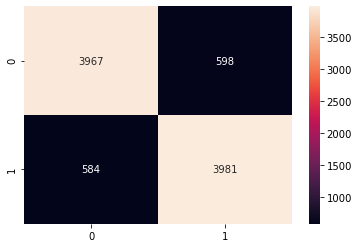

In [55]:
cf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(cf_matrix, annot=True, fmt='g')
print()

## Conclusão

O modelo que se saiu melhor nos testes realizados foi o __Random Forest__ o qual apresentou um resultado interessante, considerando os dados fornecidos. Visto que os dados utilizados, potencialmente, não são expressivos o suficiente para o prognóstico de hospitalização, o desempenho do modelo parece ser razoável. Contudo, certamente, não seria um modelo aplicável na prática, dada a seriedade do problema.